# Evaluation of the 3 datasets with ML

In [1]:
import numpy as np
import pandas as pd
import joblib
from termcolor import colored

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.figsize'] = (12, 6)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Helper functions

In [61]:
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import word_tokenize

# Required only for Colab
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def clean(text):
    """
    Provided by Le Wagon - Machine Learning - NLP
    Preprocessing articles - punctuation / lowercased / tokenize (not number) / stop_words / lemmatize
    """
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') # Remove Punctuation
    lowercased = text.lower() # Lower Case
    tokenized = word_tokenize(lowercased) # Tokenize
    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    stop_words = set(stopwords.words('english')) # Make stopword list
    without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
    lemma = WordNetLemmatizer() # Initiate Lemmatizer
    lemmatized = [lemma.lemmatize(word) for word in without_stopwords] # Lemmatize
    return lemmatized

def prep_text(texts, tokenizer, **hparams):
    """
    Turns text into into padded sequences.
    """
    # kwargs.get("local", False)
    text_sequences = tokenizer.texts_to_sequences(texts)
    return pad_sequences(text_sequences, maxlen = hparams["max_sequence_length"], padding='post')

def plot_loss(history, title=None):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))
    ax1.plot(history.history['loss'])
    ax1.plot(history.history['val_loss'])
    ax1.set_title('Model loss')
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylim(ymin=0, ymax=1)
    ax1.legend(['Train', 'Validation'], loc='best')

    ax2.plot(history.history['accuracy'])
    ax2.plot(history.history['val_accuracy'])
    ax2.set_title('ACC')
    ax2.set_ylabel('ACC')
    ax2.set_xlabel('Epoch')
    ax2.set_ylim(ymin=0, ymax=1)
    ax2.legend(['Train', 'Validation'], loc='best')

    ax3.plot(history.history['recall'])
    ax3.plot(history.history['val_recall'])
    ax3.set_title('Recall')
    ax3.set_ylabel('Recall')
    ax3.set_xlabel('Epoch')
    ax3.set_ylim(ymin=0, ymax=1)
    ax3.legend(['Train', 'Validation'], loc='best')
    if title:
        fig.suptitle(title)
    plt.show()

def binary_metrics(y_test, y_pred):
    print('-'*80)
    print('Acc: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('f1: {:.2f}'.format(f1_score(y_test, y_pred)))
    print('-'*80)
    
def get_metrics(y_test, X, model):

    y_prob = model.predict(X)
    y_pred = np.where(y_prob > 0.5, 1, 0)

    conf_matrix = confusion_matrix(y_test, y_pred)

    acc = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print('-'*80)
    print(f"acc: {acc*100:.2f}%")
    print(f"recall: {recall*100:.2f}%")
    print(f"precision: {precision*100:.2f}%")
    print(f"f1: {f1*100:.2f}%")
    print('-'*80)

    sns.heatmap(conf_matrix, annot=True, fmt="d");

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Parameters

In [23]:
hparams = {
    "batch_size": 128,
    "cnn_filter_sizes": [128, 128, 128],
    "cnn_kernel_sizes": [5, 5, 5],
    "cnn_pooling_sizes": [5, 5, 40],
    "constraint_learning_rate": 0.01,
    "embedding_dim": 100,
    "embedding_trainable": False,
    "learning_rate": 0.005,
    "max_num_words": 10000,
    "max_sequence_length": 40
}

## Loading Datasets

### Loading `politifact_scrap.csv`

In [3]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/politifact_scrap.csv'
    df = pd.read_csv(path, nrows=nrows)
    return df

data_P = get_data_from_gcp(nrows=30000)

print('-'*80)
print(f"data_P shape: {data_P.shape}")
print('-'*80)
print('-'*80)
print(data_P['category'].value_counts()/len(data_P)*100)
print('-'*80)
print(data_P['category2'].value_counts()/len(data_P)*100)
print('-'*80)

--------------------------------------------------------------------------------
data_P shape: (19826, 8)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
1    71.562595
0    28.437405
Name: category, dtype: float64
--------------------------------------------------------------------------------
1    54.206597
0    45.793403
Name: category2, dtype: float64
--------------------------------------------------------------------------------


In [24]:
X_P = data_P['statement'].apply(clean).copy()
y_P = data_P['category2'].copy()

print('-'*80)
print(f"X_P shape: {X_P.shape}")
print(f"y_P shape: {y_P.shape}")
print('-'*80)
print(f"Original text: {data_P['statement'][0]}")
print(f"Clean text: {X_P[0]}")
print('-'*80)

--------------------------------------------------------------------------------
X_P shape: (19826,)
y_P shape: (19826,)
--------------------------------------------------------------------------------
Original text: “Washington public school forces unvaccinated teens to wear ankle monitors” as a condition of playing team sports.
Clean text: ['washington', 'public', 'school', 'force', 'unvaccinated', 'teen', 'wear', 'ankle', 'monitor', 'condition', 'playing', 'team', 'sport']
--------------------------------------------------------------------------------


In [25]:
X_P_train, X_P_test, y_P_train, y_P_test = train_test_split(X_P, y_P, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_P_train shape: {X_P_train.shape}")
print(f"y_P_train shape: {y_P_train.shape}")
print('-'*80)
print(f"X_P_test shape: {X_P_test.shape}")
print(f"y_P_test shape: {y_P_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_P_train.sum()/len(y_P_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_P_test.sum()/len(y_P_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_P_train shape: (15860,)
y_P_train shape: (15860,)
--------------------------------------------------------------------------------
X_P_test shape: (3966,)
y_P_test shape: (3966,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 54.300
Fake (1) proportion in test (%): 53.833
--------------------------------------------------------------------------------


In [26]:
tokenizer_P = Tokenizer(num_words = hparams["max_num_words"])
tokenizer_P.fit_on_texts(X_P_train)

X_P_train_pad = prep_text(X_P_train, tokenizer_P, **hparams)
X_P_test_pad = prep_text(X_P_test, tokenizer_P, **hparams)

print('-'*80)
print(f"X_P_train_pad shape: {X_P_train_pad.shape}")
print(f"X_P_pad shape: {X_P_test_pad.shape}")
print('-'*80)

vocab_size = len(tokenizer_P.word_index)
print('-'*80)
print(f"vocab_size: {vocab_size}")
print('-'*80)

--------------------------------------------------------------------------------
X_P_train_pad shape: (15860, 40)
X_P_pad shape: (3966, 40)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
vocab_size: 12713
--------------------------------------------------------------------------------


### Loading `FakeNewsNET`

In [19]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/FakesNewsNET.csv'
    df = pd.read_csv(path, nrows=nrows)
    return df

data_FNN = get_data_from_gcp(nrows=20000)

print('-'*80)
print(f"data_FNN shape: {data_FNN.shape}")
print('-'*80)

--------------------------------------------------------------------------------
data_FNN shape: (19281, 8)
--------------------------------------------------------------------------------


In [20]:
X_FNN = data_FNN['title'].apply(clean).copy()
y_FNN = data_FNN['category'].copy()

print('-'*80)
print(f"X_FNN shape: {X_FNN.shape}")
print(f"y_FNN shape: {y_FNN.shape}")
print('-'*80)
print(f"Original text: {data_FNN['title'][0]}")
print(f"Clean text: {X_FNN[0]}")
print('-'*80)

--------------------------------------------------------------------------------
X_FNN shape: (19281,)
y_FNN shape: (19281,)
--------------------------------------------------------------------------------
Original text: Djou wins special election for Congress
Clean text: ['djou', 'win', 'special', 'election', 'congress']
--------------------------------------------------------------------------------


In [21]:
X_FNN_train, X_FNN_test, y_FNN_train, y_FNN_test = train_test_split(X_FNN, y_FNN, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_FNN_train shape: {X_FNN_train.shape}")
print(f"y_FNN_train shape: {y_FNN_train.shape}")
print('-'*80)
print(f"X_FNN_test shape: {X_FNN_test.shape}")
print(f"y_FNN_test shape: {y_FNN_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_FNN_train.sum()/len(y_FNN_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_FNN_test.sum()/len(y_FNN_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_FNN_train shape: (15424,)
y_FNN_train shape: (15424,)
--------------------------------------------------------------------------------
X_FNN_test shape: (3857,)
y_FNN_test shape: (3857,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 24.870
Fake (1) proportion in test (%): 23.568
--------------------------------------------------------------------------------


In [22]:
tokenizer_F = Tokenizer(num_words = hparams["max_num_words"])
tokenizer_F.fit_on_texts(X_P_train)

X_FNN_train_pad = prep_text(X_FNN_train, tokenizer_F, **hparams)
X_FNN_test_pad = prep_text(X_FNN_test, tokenizer_F, **hparams)

print('-'*80)
print(f"X_FNN_train_pad shape: {X_FNN_train_pad.shape}")
print(f"X_FNN_pad shape: {X_FNN_test_pad.shape}")
print('-'*80)

vocab_size = len(tokenizer_F.word_index)
print('-'*80)
print(f"vocab_size: {vocab_size}")
print('-'*80)

--------------------------------------------------------------------------------
X_FNN_train_pad shape: (15424, 250)
X_FNN_pad shape: (3857, 250)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
vocab_size: 12713
--------------------------------------------------------------------------------


### Loading `Bisaillon`

In [27]:
def get_data_from_gcp(nrows=10000, optimize=False, **kwargs):
    """method to get the training data (or a portion of it) from GCP"""
    true_path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/True.csv'
    fake_path = 'https://storage.googleapis.com/wagon-data-615-seguy/data/Fake.csv'
    true_df = pd.read_csv(true_path, nrows=nrows)
    fake_df = pd.read_csv(fake_path, nrows=nrows)
    return true_df, fake_df

true, fake = get_data_from_gcp(nrows=None)

print('-'*80)
print(f"true shape: {true.shape}")
print(f"fake shape: {fake.shape}")
print('-'*80)

--------------------------------------------------------------------------------
true shape: (21417, 4)
fake shape: (23481, 4)
--------------------------------------------------------------------------------


In [28]:
true.drop_duplicates(inplace=True)
fake.drop_duplicates(inplace=True)

print('-'*80)
print(f"true shape (wo duplicates): {true.shape}")
print(f"fake shape (wo duplicates): {fake.shape}")
print('-'*80)

--------------------------------------------------------------------------------
true shape (wo duplicates): (21211, 4)
fake shape (wo duplicates): (23478, 4)
--------------------------------------------------------------------------------


In [29]:
true['category'] = 0
fake['category'] = 1

data_BIS = pd.concat([true, fake]).reset_index(drop=True)

print('-'*80)
print(f"data_BIS shape: {data_BIS.shape}")
print('-'*80)
print(f"ratio #true: {len(data_BIS[data_BIS['category']==0])/len(data_BIS)*100:.2f}%")
print(f"ratio #fake: {len(data_BIS[data_BIS['category']==1])/len(data_BIS)*100:.2f}%")
print('-'*80)

--------------------------------------------------------------------------------
data_BIS shape: (44689, 5)
--------------------------------------------------------------------------------
ratio #true: 47.46%
ratio #fake: 52.54%
--------------------------------------------------------------------------------


In [30]:
X_BIS = data_BIS['title'].apply(clean).copy()
y_BIS = data_BIS['category'].copy()

print('-'*80)
print(f"X_BIS shape: {X_BIS.shape}")
print(f"y_BIS shape: {y_BIS.shape}")
print('-'*80)
print(f"Original text: {data_BIS['title'][0]}")
print(f"Clean text: {X_BIS[0]}")
print('-'*80)

--------------------------------------------------------------------------------
X_BIS shape: (44689,)
y_BIS shape: (44689,)
--------------------------------------------------------------------------------
Original text: As U.S. budget fight looms, Republicans flip their fiscal script
Clean text: ['u', 'budget', 'fight', 'loom', 'republican', 'flip', 'fiscal', 'script']
--------------------------------------------------------------------------------


In [31]:
X_BIS_train, X_BIS_test, y_BIS_train, y_BIS_test = train_test_split(X_BIS, y_BIS, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_BIS_train shape: {X_BIS_train.shape}")
print(f"y_BIS_train shape: {y_BIS_train.shape}")
print('-'*80)
print(f"X_BIS_test shape: {X_BIS_test.shape}")
print(f"y_BIS_test shape: {y_BIS_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_BIS_train.sum()/len(y_BIS_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_BIS_test.sum()/len(y_BIS_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_BIS_train shape: (35751,)
y_BIS_train shape: (35751,)
--------------------------------------------------------------------------------
X_BIS_test shape: (8938,)
y_BIS_test shape: (8938,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 52.670
Fake (1) proportion in test (%): 52.003
--------------------------------------------------------------------------------


In [32]:
tokenizer_B = Tokenizer(num_words = hparams["max_num_words"])
tokenizer_B.fit_on_texts(X_P_train)

X_BIS_train_pad = prep_text(X_BIS_train, tokenizer_B, **hparams)
X_BIS_test_pad = prep_text(X_BIS_test, tokenizer_B, **hparams)

print('-'*80)
print(f"X_BIS_train_pad shape: {X_BIS_train_pad.shape}")
print(f"X_BIS_pad shape: {X_BIS_test_pad.shape}")
print('-'*80)

vocab_size = len(tokenizer_B.word_index)
print('-'*80)
print(f"vocab_size: {vocab_size}")
print('-'*80)

--------------------------------------------------------------------------------
X_BIS_train_pad shape: (35751, 40)
X_BIS_pad shape: (8938, 40)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
vocab_size: 12713
--------------------------------------------------------------------------------


### Merging `All`

In [36]:
X_all = pd.concat([X_P, X_FNN, X_BIS]).reset_index(drop=True)
y_all = pd.concat([y_P, y_FNN, y_BIS]).reset_index(drop=True)

print('-'*80)
print(f"X_all shape: {X_all.shape}")
print(f"y_all shape: {y_all.shape}")
print('-'*80)

--------------------------------------------------------------------------------
X_all shape: (83796,)
y_all shape: (83796,)
--------------------------------------------------------------------------------


In [37]:
X_ALL_train, X_ALL_test, y_ALL_train, y_ALL_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

print('-'*80)
print(f"X_ALL_train shape: {X_ALL_train.shape}")
print(f"y_ALL_train shape: {y_ALL_train.shape}")
print('-'*80)
print(f"X_ALL_test shape: {X_ALL_test.shape}")
print(f"y_ALL_test shape: {y_ALL_test.shape}")
print('-'*80)
print('-'*80)
print(f"Fake (1) proportion in train (%): {y_ALL_train.sum()/len(y_ALL_train)*100:.3f}")
print(f"Fake (1) proportion in test (%): {y_ALL_test.sum()/len(y_ALL_test)*100:.3f}")
print('-'*80)

--------------------------------------------------------------------------------
X_ALL_train shape: (67036,)
y_ALL_train shape: (67036,)
--------------------------------------------------------------------------------
X_ALL_test shape: (16760,)
y_ALL_test shape: (16760,)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Fake (1) proportion in train (%): 46.453
Fake (1) proportion in test (%): 46.718
--------------------------------------------------------------------------------


In [38]:
tokenizer_ALL = Tokenizer(num_words = hparams["max_num_words"])
tokenizer_ALL.fit_on_texts(X_ALL_train)

X_ALL_train_pad = prep_text(X_ALL_train, tokenizer_ALL, **hparams)
X_ALL_test_pad = prep_text(X_ALL_test, tokenizer_ALL, **hparams)

print('-'*80)
print(f"X_ALL_train_pad shape: {X_ALL_train_pad.shape}")
print(f"X_ALL_pad shape: {X_ALL_test_pad.shape}")
print('-'*80)

vocab_size = len(tokenizer_ALL.word_index)
print('-'*80)
print(f"vocab_size: {vocab_size}")
print('-'*80)

--------------------------------------------------------------------------------
X_ALL_train_pad shape: (67036, 40)
X_ALL_pad shape: (16760, 40)
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
vocab_size: 25526
--------------------------------------------------------------------------------


## Model

In [39]:
import io
import urllib
import zipfile

def get_embedding(**hparams):
    """
    Pre-trained GloVe word vector embeddings
    """
    zip_file_url = "http://nlp.stanford.edu/data/glove.6B.zip"
    zip_file = urllib.request.urlopen(zip_file_url)
    archive = zipfile.ZipFile(io.BytesIO(zip_file.read()))

    embeddings_index = {}
    glove_file = "glove.6B.100d.txt"

    with archive.open(glove_file) as f:
        for line in f:
            values = line.split()
            word = values[0].decode("utf-8") 
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, hparams["embedding_dim"]))
    num_words_in_embedding = 0
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            num_words_in_embedding += 1
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

embedding_matrix = get_embedding(**hparams)
print('-'*80)
print(f"embedding_matrix shape: {embedding_matrix.shape}")
print('-'*80)

--------------------------------------------------------------------------------
embedding_matrix shape: (12714, 100)
--------------------------------------------------------------------------------


In [40]:
METRICS = [
    #   tf.keras.metrics.TruePositives(name='tp'),
    #   tf.keras.metrics.FalsePositives(name='fp'),
    #   tf.keras.metrics.TrueNegatives(name='tn'),
    #   tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
]

def init_model(metrics=METRICS, **hparams):
    model = tf.keras.models.Sequential()

    # Embedding layer.
    embedding_layer = tf.keras.layers.Embedding(
        embedding_matrix.shape[0],
        embedding_matrix.shape[1],
        weights = [embedding_matrix],
        input_length = hparams["max_sequence_length"],
        trainable = hparams['embedding_trainable'],
        mask_zero = True)
    model.add(embedding_layer)

    # Convolution layers.
    for filter_size, kernel_size, pool_size in zip(
        hparams['cnn_filter_sizes'], hparams['cnn_kernel_sizes'],
        hparams['cnn_pooling_sizes']):

        conv_layer = tf.keras.layers.Conv1D(
            filter_size, kernel_size, activation='relu', padding='same')
        model.add(conv_layer)

        pooled_layer = tf.keras.layers.MaxPooling1D(pool_size, padding='same')
        model.add(pooled_layer)

    # Add a flatten layer, a fully-connected layer and an output layer.
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(1, activation="sigmoid"))

    # Compile the model
    optimizer = tf.keras.optimizers.Adam(learning_rate=hparams["learning_rate"])
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=METRICS)

    return model

In [41]:
init_model(**hparams).summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 100)           1271400   
_________________________________________________________________
conv1d (Conv1D)              (None, 40, 128)           64128     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 8, 128)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 128)            82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 2, 128)            82048     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 1, 128)            0

## `politifact_scrap.csv`

### Training

In [46]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=8, restore_best_weights=True)
# es = tf.keras.callbacks.EarlyStopping(monitor='val_recall', mode='max', patience=8, restore_best_weights=True)

P_model = init_model(**hparams)

history = P_model.fit(X_P_train_pad, 
                  y_P_train,
                  validation_split=0.2,
                  batch_size=hparams["batch_size"],
                  epochs=30, 
                  callbacks=[es],
                  verbose=1)

Epoch 1/30
100/100 [==============================] - 3s 20ms/step - loss: 0.6553 - accuracy: 0.6107 - precision: 0.6218 - recall: 0.7225 - val_loss: 0.6240 - val_accuracy: 0.6419 - val_precision: 0.7214 - val_recall: 0.5606
Epoch 2/30
100/100 [==============================] - 1s 14ms/step - loss: 0.6069 - accuracy: 0.6598 - precision: 0.7042 - recall: 0.6424 - val_loss: 0.6259 - val_accuracy: 0.6488 - val_precision: 0.6774 - val_recall: 0.6813
Epoch 3/30
100/100 [==============================] - 1s 14ms/step - loss: 0.5698 - accuracy: 0.6903 - precision: 0.7505 - recall: 0.6423 - val_loss: 0.6521 - val_accuracy: 0.6217 - val_precision: 0.7235 - val_recall: 0.4971
Epoch 4/30
100/100 [==============================] - 1s 14ms/step - loss: 0.5120 - accuracy: 0.7302 - precision: 0.8007 - recall: 0.6690 - val_loss: 0.7946 - val_accuracy: 0.6321 - val_precision: 0.6558 - val_recall: 0.6865
Epoch 5/30
100/100 [==============================] - 1s 14ms/step - loss: 0.4555 - accuracy: 0.7640

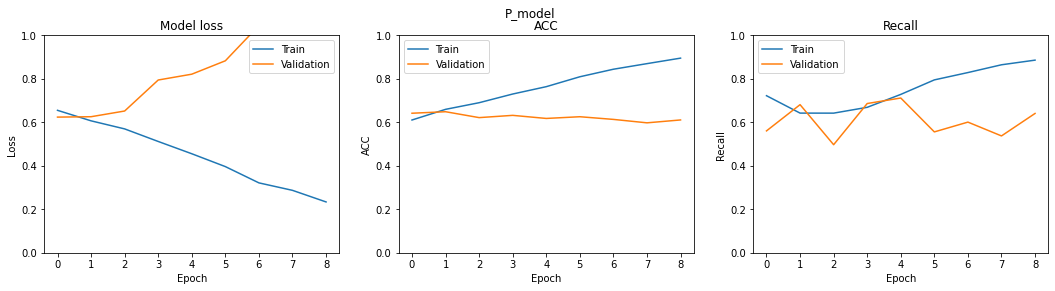

In [50]:
plot_loss(history, title='P_model')

--------------------------------------------------------------------------------
acc: 64.04%
recall: 55.74%
precision: 71.21%
f1: 62.53%
--------------------------------------------------------------------------------


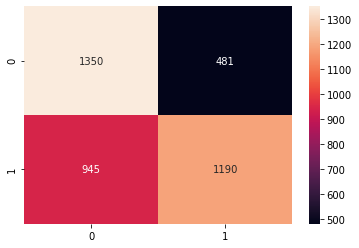

In [54]:
get_metrics(y_P_test, X_P_test_pad, P_model)

### Saving the model

In [55]:
model_name = 'P_model'

P_model.save(model_name)

INFO:tensorflow:Assets written to: P_model/assets


### Uploading the model

In [57]:
reconstructed_P_model = tf.keras.models.load_model("P_model")

--------------------------------------------------------------------------------
acc: 64.04%
recall: 55.74%
precision: 71.21%
f1: 62.53%
--------------------------------------------------------------------------------


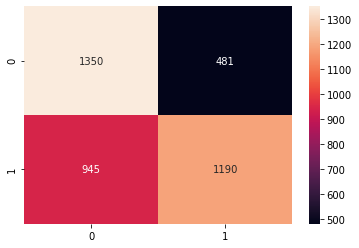

In [58]:
get_metrics(y_P_test, X_P_test_pad, reconstructed_P_model)

### `P_model.joblib` evaluation on `FakeNewsNET`

--------------------------------------------------------------------------------
acc: 31.07%
recall: 93.45%
precision: 25.46%
f1: 40.02%
--------------------------------------------------------------------------------


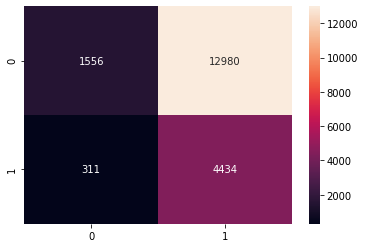

In [81]:
X_FNN_pad = prep_text(X_FNN, tokenizer_P, **hparams)

get_metrics(y_FNN, X_FNN_pad, reconstructed_P_model)

### `P_model.joblib` evaluation on `Bisaillon`

--------------------------------------------------------------------------------
acc: 57.39%
recall: 92.63%
precision: 55.68%
f1: 69.55%
--------------------------------------------------------------------------------


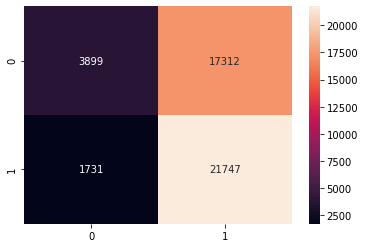

In [82]:
X_BIS_pad = prep_text(X_BIS, tokenizer_P, **hparams)

get_metrics(y_BIS, X_BIS_pad, reconstructed_P_model)

## `FakeNewsNET`

### Training

In [71]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=8, restore_best_weights=True)
# es = tf.keras.callbacks.EarlyStopping(monitor='val_recall', mode='max', patience=8, restore_best_weights=True)

F_model = init_model(**hparams)

history = F_model.fit(X_FNN_train_pad, 
                  y_FNN_train,
                  validation_split=0.2,
                  batch_size=hparams["batch_size"],
                  epochs=30, 
                  callbacks=[es],
                  verbose=1)

Epoch 1/30
97/97 [==============================] - 4s 31ms/step - loss: 0.5351 - accuracy: 0.7654 - precision: 0.8478 - recall: 0.0697 - val_loss: 0.4851 - val_accuracy: 0.7485 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/30
97/97 [==============================] - 2s 25ms/step - loss: 0.4629 - accuracy: 0.7892 - precision: 0.6745 - recall: 0.2899 - val_loss: 0.4670 - val_accuracy: 0.7890 - val_precision: 0.6233 - val_recall: 0.4072
Epoch 3/30
97/97 [==============================] - 2s 25ms/step - loss: 0.3985 - accuracy: 0.8232 - precision: 0.7047 - recall: 0.4944 - val_loss: 0.4677 - val_accuracy: 0.7841 - val_precision: 0.5979 - val_recall: 0.4330
Epoch 4/30
97/97 [==============================] - 2s 25ms/step - loss: 0.3245 - accuracy: 0.8583 - precision: 0.7488 - recall: 0.6448 - val_loss: 0.5007 - val_accuracy: 0.7780 - val_precision: 0.5938 - val_recall: 0.3711
Epoch 5/30
97/97 [==============================] - 2s 26ms/step - loss: 0.2518 - accuracy: 0.8925 -

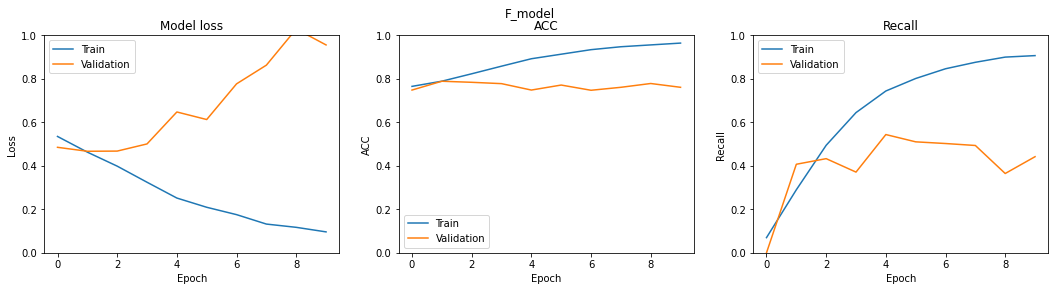

In [73]:
plot_loss(history, title='F_model')

--------------------------------------------------------------------------------
acc: 78.43%
recall: 38.28%
precision: 56.22%
f1: 45.55%
--------------------------------------------------------------------------------


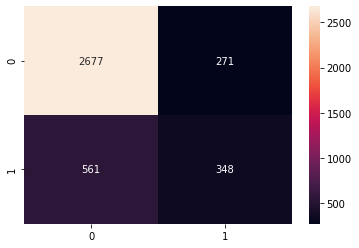

In [74]:
get_metrics(y_FNN_test, X_FNN_test_pad, F_model)

### Saving the model

In [76]:
model_name = 'F_model'

F_model.save(model_name)

INFO:tensorflow:Assets written to: F_model/assets


### Uploading the model

In [78]:
reconstructed_F_model = tf.keras.models.load_model("F_model")

--------------------------------------------------------------------------------
acc: 78.43%
recall: 38.28%
precision: 56.22%
f1: 45.55%
--------------------------------------------------------------------------------


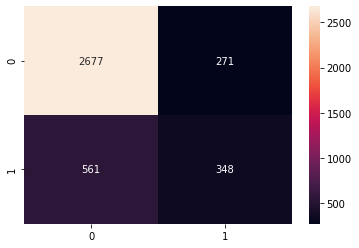

In [79]:
get_metrics(y_FNN_test, X_FNN_test_pad, reconstructed_F_model)

### `F_model.joblib` evaluation on `Bisaillon`

--------------------------------------------------------------------------------
acc: 49.50%
recall: 28.48%
precision: 53.65%
f1: 37.21%
--------------------------------------------------------------------------------


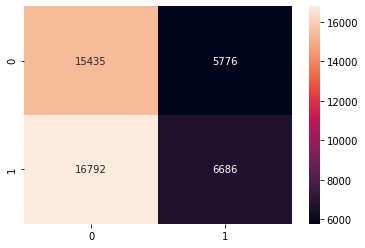

In [80]:
X_BIS_pad = prep_text(X_BIS, tokenizer_F, **hparams)

get_metrics(y_BIS, X_BIS_pad, reconstructed_F_model)

### `F_model.joblib` evaluation on  `politifact_scrap`

--------------------------------------------------------------------------------
acc: 49.63%
recall: 27.74%
precision: 57.32%
f1: 37.38%
--------------------------------------------------------------------------------


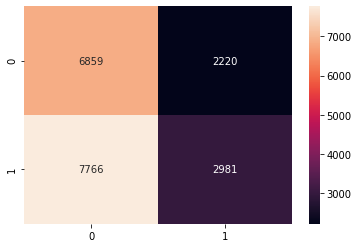

In [83]:
X_P_pad = prep_text(X_P, tokenizer_F, **hparams)

get_metrics(y_P, X_P_pad, reconstructed_F_model)

## `Bisaillon`

### Training

In [85]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=8, restore_best_weights=True)
# es = tf.keras.callbacks.EarlyStopping(monitor='val_recall', mode='max', patience=8, restore_best_weights=True)

B_model = init_model(**hparams)

history = B_model.fit(X_BIS_train_pad, 
                  y_BIS_train,
                  validation_split=0.2,
                  batch_size=hparams["batch_size"],
                  epochs=30, 
                  callbacks=[es],
                  verbose=1)

Epoch 1/30
224/224 [==============================] - 5s 18ms/step - loss: 0.2546 - accuracy: 0.9154 - precision: 0.9262 - recall: 0.9128 - val_loss: 0.2170 - val_accuracy: 0.9102 - val_precision: 0.9493 - val_recall: 0.8745
Epoch 2/30
224/224 [==============================] - 3s 15ms/step - loss: 0.1637 - accuracy: 0.9374 - precision: 0.9473 - recall: 0.9335 - val_loss: 0.1947 - val_accuracy: 0.9259 - val_precision: 0.9171 - val_recall: 0.9431
Epoch 3/30
224/224 [==============================] - 3s 14ms/step - loss: 0.1169 - accuracy: 0.9556 - precision: 0.9629 - recall: 0.9527 - val_loss: 0.2045 - val_accuracy: 0.9276 - val_precision: 0.9321 - val_recall: 0.9286
Epoch 4/30
224/224 [==============================] - 3s 15ms/step - loss: 0.0854 - accuracy: 0.9674 - precision: 0.9733 - recall: 0.9647 - val_loss: 0.1974 - val_accuracy: 0.9267 - val_precision: 0.9428 - val_recall: 0.9150
Epoch 5/30
224/224 [==============================] - 3s 14ms/step - loss: 0.0628 - accuracy: 0.9760

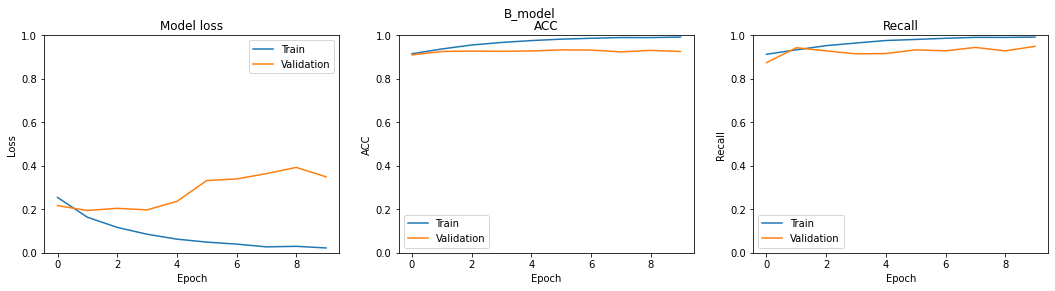

In [86]:
plot_loss(history, title='B_model')

--------------------------------------------------------------------------------
acc: 93.05%
recall: 95.01%
precision: 91.90%
f1: 93.43%
--------------------------------------------------------------------------------


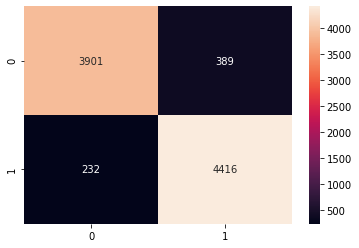

In [87]:
get_metrics(y_BIS_test, X_BIS_test_pad, B_model)

### Saving the model

In [89]:
model_name = 'B_model'

B_model.save(model_name)

INFO:tensorflow:Assets written to: B_model/assets


### Uploading the model

In [90]:
reconstructed_B_model = tf.keras.models.load_model("B_model")

--------------------------------------------------------------------------------
acc: 93.05%
recall: 95.01%
precision: 91.90%
f1: 93.43%
--------------------------------------------------------------------------------


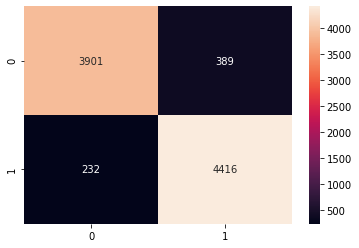

In [91]:
get_metrics(y_BIS_test, X_BIS_test_pad, reconstructed_B_model)

### `B_model.joblib` evaluation on `FakeNewsNET`

--------------------------------------------------------------------------------
acc: 34.99%
recall: 83.18%
precision: 25.17%
f1: 38.64%
--------------------------------------------------------------------------------


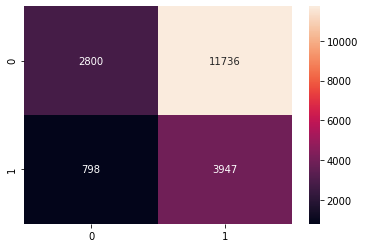

In [92]:
X_FNN_pad = prep_text(X_FNN, tokenizer_B, **hparams)

get_metrics(y_FNN, X_FNN_pad, reconstructed_B_model)

### `B_model.joblib` evaluation on `politifact scrap`

--------------------------------------------------------------------------------
acc: 54.30%
recall: 78.21%
precision: 55.58%
f1: 64.98%
--------------------------------------------------------------------------------


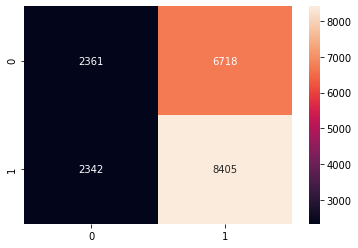

In [93]:
X_P_pad = prep_text(X_P, tokenizer_B, **hparams)

get_metrics(y_P, X_P_pad, reconstructed_B_model)

## `All`

### Training

In [94]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', patience=8, restore_best_weights=True)
# es = tf.keras.callbacks.EarlyStopping(monitor='val_recall', mode='max', patience=8, restore_best_weights=True)

ALL_model = init_model(**hparams)

history = ALL_model.fit(X_ALL_train_pad, 
                  y_ALL_train,
                  validation_split=0.2,
                  batch_size=hparams["batch_size"],
                  epochs=30, 
                  callbacks=[es],
                  verbose=1)

Epoch 1/30
419/419 [==============================] - 8s 16ms/step - loss: 0.5405 - accuracy: 0.7433 - precision: 0.7683 - recall: 0.6508 - val_loss: 0.5103 - val_accuracy: 0.7358 - val_precision: 0.7090 - val_recall: 0.7361
Epoch 2/30
419/419 [==============================] - 6s 14ms/step - loss: 0.4652 - accuracy: 0.7720 - precision: 0.7851 - recall: 0.7001 - val_loss: 0.4779 - val_accuracy: 0.7616 - val_precision: 0.7856 - val_recall: 0.6731
Epoch 3/30
419/419 [==============================] - 6s 14ms/step - loss: 0.4062 - accuracy: 0.8067 - precision: 0.8181 - recall: 0.7502 - val_loss: 0.5288 - val_accuracy: 0.7508 - val_precision: 0.7334 - val_recall: 0.7325
Epoch 4/30
419/419 [==============================] - 6s 14ms/step - loss: 0.3533 - accuracy: 0.8359 - precision: 0.8483 - recall: 0.7871 - val_loss: 0.5112 - val_accuracy: 0.7577 - val_precision: 0.7607 - val_recall: 0.7017
Epoch 5/30
419/419 [==============================] - 6s 14ms/step - loss: 0.3057 - accuracy: 0.8622

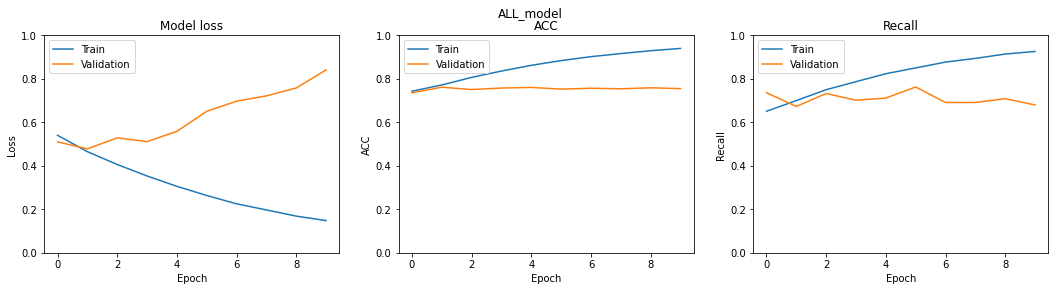

In [95]:
plot_loss(history, title='ALL_model')

--------------------------------------------------------------------------------
acc: 75.69%
recall: 66.40%
precision: 78.27%
f1: 71.85%
--------------------------------------------------------------------------------


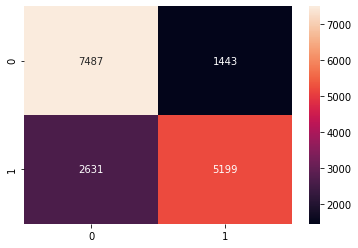

In [96]:
get_metrics(y_ALL_test, X_ALL_test_pad, ALL_model)

### Saving the model

In [97]:
model_name = 'ALL_model'

ALL_model.save(model_name)

INFO:tensorflow:Assets written to: ALL_model/assets


### Uploading the model

In [98]:
reconstructed_ALL_model = tf.keras.models.load_model("ALL_model")

--------------------------------------------------------------------------------
acc: 75.69%
recall: 66.40%
precision: 78.27%
f1: 71.85%
--------------------------------------------------------------------------------


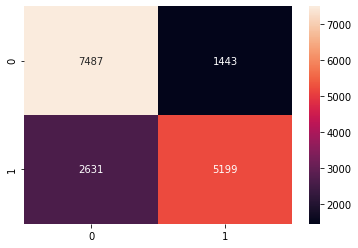

In [99]:
get_metrics(y_ALL_test, X_ALL_test_pad, reconstructed_ALL_model)

### `ALL_model.joblib` evaluation on `politifact_scrap`

--------------------------------------------------------------------------------
acc: 61.98%
recall: 53.49%
precision: 68.92%
f1: 60.23%
--------------------------------------------------------------------------------


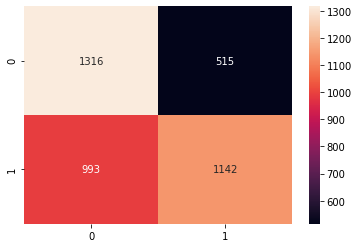

In [102]:
X_P_test_pad = prep_text(X_P_test, tokenizer_ALL, **hparams)

get_metrics(y_P_test, X_P_test_pad, reconstructed_ALL_model)

### `ALL_model.joblib` evaluation on `FakeNewsNET`

--------------------------------------------------------------------------------
acc: 77.65%
recall: 46.31%
precision: 52.96%
f1: 49.41%
--------------------------------------------------------------------------------


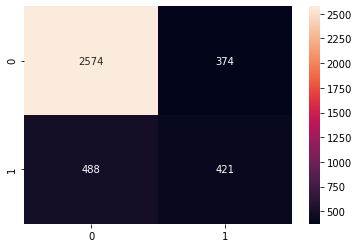

In [103]:
X_FNN_test_pad = prep_text(X_FNN_test, tokenizer_ALL, **hparams)

get_metrics(y_FNN_test, X_FNN_test_pad, reconstructed_ALL_model)

### `ALL_model.joblib` evaluation on `Bisaillon`

--------------------------------------------------------------------------------
acc: 89.62%
recall: 85.52%
precision: 93.97%
f1: 89.55%
--------------------------------------------------------------------------------


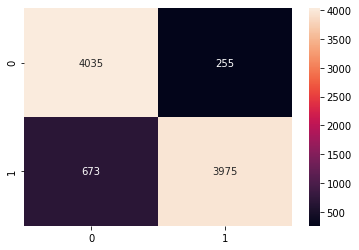

In [104]:
X_BIS_test_pad = prep_text(X_BIS_test, tokenizer_ALL, **hparams)

get_metrics(y_BIS_test, X_BIS_test_pad, reconstructed_ALL_model)

## Prediction - TO BE DONE

In [ ]:
# model_name = '../raw_data/ALL_model.joblib'

# model = get_model(model_name)

In [ ]:
# fake0 = "White House, CDC, WHO and vaccine makers don’t require the COVID-19 vaccine for their workers."
# fake1 = "Says a U.S. Air Force-insignia plane evacuating people from Afghanistan is fake."
# fake2 = "No one has died of cancer or heart disease since the COVID-19 thing started."
# true0 = "A photo shows two COVID-19 patients lying on the floor awaiting treatment in Florida."
# true1 = "We’ve got 115,000 miles of roads in this state and 90% is owned by the locals."
# true2 = "324,000 pregnant people experience domestic violence during their pregnancy."

In [ ]:
# sample = [fake0, fake1, fake2, true0, true1, true2]

# X_sample_clean = [clean(text) for text in sample] 
# # X_sample_clean = sample
# # print(X_sample_clean)

# y_preds = model.predict_proba(X_sample_clean)[:, 1]

# print('-'*80)
# print(y_preds)
# print('-'*80)

--------------------------------------------------------------------------------
[0.83834652 0.344895   0.61034863 0.55931642 0.32220998 0.26828418]
--------------------------------------------------------------------------------
